In [1]:
import h5py
from torch.autograd import Variable
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.models as models
from tqdm import tqdm

import config
import data
import utils
#import resnet as caffe_resnet
import torchvision as tv
import json
from collections import Counter
import itertools

import config
import data
import utils
import torch
import model
import json
import os
import os.path
import re

from PIL import Image
import h5py
import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import config
import utils
from scipy.ndimage.filters import gaussian_filter
import cv2
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
log = torch.load('logs/Fully_Bat.pth')
tokens = len(log['vocab']['question']) + 1
net = torch.nn.DataParallel(model.Net(tokens))
net.load_state_dict(log['weights'])

In [5]:
_special_chars = re.compile('[^a-z0-9 ]*')

_period_strip = re.compile(r'(?!<=\d)(\.)(?!\d)')
_comma_strip = re.compile(r'(\d)(,)(\d)')
_punctuation_chars = re.escape(r';/[]"{}()=+\_-><@`,?!')
_punctuation = re.compile(r'([{}])'.format(re.escape(_punctuation_chars)))
_punctuation_with_a_space = re.compile(r'(?<= )([{0}])|([{0}])(?= )'.format(_punctuation_chars))

In [26]:
class VQA(data.Dataset):
    """ VQA dataset, open-ended """
    def __init__(self, questions_path, image_features_path, answerable_only=False):
        super(VQA, self).__init__()
        with open(questions_path, 'r') as fd:
            questions_json = json.load(fd)
        with open(config.vocabulary_path, 'r') as fd:
            vocab_json = json.load(fd)

        # vocab
        self.vocab = vocab_json
        self.token_to_index = self.vocab['question']

        # q and a
        self.questions = list(prepare_questions(questions_json))
        self.questions = [self._encode_question(q) for q in self.questions]

        # v
        self.image_features_path = image_features_path
        self.coco_id_to_index = self._create_coco_id_to_index()
        self.coco_ids = [q['image_id'] for q in questions_json['questions']]

        # only use questions that have at least one answer?
        self.answerable_only = answerable_only
        if self.answerable_only:
            self.answerable = self._find_answerable()

    @property
    def max_question_length(self):
        if not hasattr(self, '_max_length'):
            self._max_length = max(map(len, self.questions))
        return self._max_length

    @property
    def num_tokens(self):
        return len(self.token_to_index) + 1  # add 1 for <unknown> token at index 0

    def _create_coco_id_to_index(self):
        """ Create a mapping from a COCO image id into the corresponding index into the h5 file """
        with h5py.File(self.image_features_path, 'r') as features_file:
            coco_ids = features_file['ids'][()]
        coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}
        return coco_id_to_index

    def _check_integrity(self, questions, answers):
        """ Verify that we are using the correct data """
        qa_pairs = list(zip(questions['questions'], answers['annotations']))
        assert all(q['question_id'] == a['question_id'] for q, a in qa_pairs), 'Questions not aligned with answers'
        assert all(q['image_id'] == a['image_id'] for q, a in qa_pairs), 'Image id of question and answer don\'t match'
        assert questions['data_type'] == answers['data_type'], 'Mismatched data types'
        assert questions['data_subtype'] == answers['data_subtype'], 'Mismatched data subtypes'

    def _find_answerable(self):
        """ Create a list of indices into questions that will have at least one answer that is in the vocab """
        answerable = []
        for i, answers in enumerate(self.answers):
            answer_has_index = len(answers.nonzero()) > 0
            # store the indices of anything that is answerable
            if answer_has_index:
                answerable.append(i)
        return answerable

    def _encode_question(self, question):
        """ Turn a question into a vector of indices and a question length """
        vec = torch.zeros(self.max_question_length).long()
        for i, token in enumerate(question):
            index = self.token_to_index.get(token, 0)
            vec[i] = index
        return vec, len(question)

    def _encode_answers(self, answers):
        """ Turn an answer into a vector """
        # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
        # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
        # to get the loss that is weighted by how many humans gave that answer
        answer_vec = torch.zeros(len(self.answer_to_index))
        for answer in answers:
            index = self.answer_to_index.get(answer)
            if index is not None:
                answer_vec[index] += 1
        return answer_vec

    def _load_image(self, image_id):
        """ Load an image """
        if not hasattr(self, 'features_file'):
            # Loading the h5 file has to be done here and not in __init__ because when the DataLoader
            # forks for multiple works, every child would use the same file object and fail
            # Having multiple readers using different file objects is fine though, so we just init in here.
            self.features_file = h5py.File(self.image_features_path, 'r')
        index = self.coco_id_to_index[image_id]
        dataset = self.features_file['features']
        img = dataset[index].astype('float32')
        return torch.from_numpy(img)

    def __getitem__(self, item):
        if self.answerable_only:
            # change of indices to only address answerable questions
            item = self.answerable[item]

        q, q_length = self.questions[item]
        image_id = self.coco_ids[item]
        print(image_id, q_length)
        v = self._load_image(image_id)
        # since batches are re-ordered for PackedSequence's, the original question order is lost
        # we return `item` so that the order of (v, q, a) triples can be restored if desired
        # without shuffling in the dataloader, these will be in the order that they appear in the q and a json's.
        return v, q, item, q_length, image_id

    def __len__(self):
        if self.answerable_only:
            return len(self.answerable)
        else:
            return len(self.questions)
        
        
def prepare_questions(questions_json):
    """ Tokenize and normalize questions from a given question json in the usual VQA format. """
    questions = [q['question'] for q in questions_json['questions']]
    for question in questions:
        question = question.lower()[:-1]
        yield question.split(' ')
        
def collate_fn(batch):
    # put question lengths in descending order so that we can use packed sequences later
    batch.sort(key=lambda x: x[-1], reverse=True)
    return data.dataloader.default_collate(batch)

In [27]:
split = VQA(
    'vqa/test2015_questions.json',
    config.preprocessed_test_path,
    answerable_only=False,
)

loader = torch.utils.data.DataLoader(
    split,
    batch_size=1,
    shuffle=False,  # only shuffle the data in training
    pin_memory=True,
    num_workers=config.data_workers,
    collate_fn=collate_fn,
)

In [28]:
net.eval()
tq = tqdm(loader)

  0%|          | 0/33 [00:00<?, ?it/s]

In [51]:
i = 0
answ = []
att = []
image_id = []
ques_len = []
im = []
i = 0
for v, q, idx, q_len, imid in tq:
    var_params = {
        'volatile': not False,
        'requires_grad': False,
    }
    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    im.append(v)
    image_id.append(imid)
    ques_len.append(q_len)
    q_len = Variable(q_len.cuda(async=True), **var_params)
    out, a = net(v, q, q_len)
    import torch.nn.functional as F
    a = a.view(2, -1)
    a = F.softmax(a, dim=-1)
    att.append(a)
    _, answer = out.data.cpu().max(dim=1)
    answ.append(answer.view(-1))
answ = list(torch.cat(answ, dim=0))
    

419588 4
223814 4
223814 6
419588 9
419588 5
223814 4
318140 8
318140 5
318140 5
470027 5
574926 4
30753 5
30753 5
30753 8
574926 4
470027 6
574926 6
470027 8
454055 6
454055 6
454055 6
203407 5
203407 6
203407 5
335168 6
335168 7
335168 6
80975 5
80975 4
80975 5
432284 10


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


432284 7
432284 7


In [52]:
%matplotlib notebook
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.gridspec as grd

In [53]:
from os import listdir
from PIL import Image as PImage
import numpy as np

def normalize(x):
    for i in range(x.shape[0]):
        maxi = x[i, :, :].max()
        mini = x[i, :, :].min()
        x[i, :, :] = 2*(x[i, :, :] - mini)/(maxi - mini) - 1
    return x

In [150]:
i = 24
zero = '000000'
img = str(image_id[i].item())
img = zero[:len(zero) - len(img)] + img
img_path = 'mscoco/test2015/COCO_test2015_000000' + img + '.jpg'
img = Image.open(img_path).convert('RGB')

transform = tv.transforms.Compose([tv.transforms.Resize((448, 448)), tv.transforms.ToTensor(), tv.transforms.Lambda(normalize)])
x = transform(img)
x.shape

y = x.numpy()
y.shape
y = np.moveaxis(y, [0, 1, 2], [2, 0, 1])
y.shape

(448, 448, 3)

In [151]:
att_map = att[i].detach()
#print(att_map.shape)
att_map = att_map.view(2, 14, 14)
att_map = att_map.to('cpu').numpy()
att_map_comp = att_map
att_map = att_map_comp[0]
att_map = att_map.repeat(32, axis=0).repeat(32, axis=1)


att_map.shape

(448, 448)

In [152]:
# att_map = att_map.repeat(7, axis=0).repeat(7, axis=1)
att_map = np.tile(np.expand_dims(att_map, 2),[1,1,3])

att_map[:,:,1:] = 0
att_map = gaussian_filter(att_map, sigma=20)
att_map = (att_map-att_map.min()) / att_map.max()
att_map = cv2.resize(att_map, (y.shape[1], y.shape[0]))
att_map.shape

(448, 448, 3)

<IPython.core.display.Javascript object>


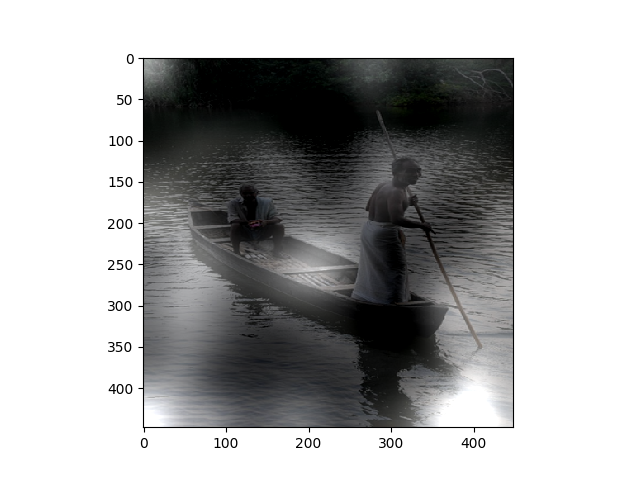

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [154]:
image = att_map*0.8 + y*0.2
# image = (image + 1) / 2
# image[image < 0] = 0
# image[image > 1] = 1
plt.imshow(image)

In [136]:
att_map = att[9].detach()

In [ ]:
att_map

In [137]:
a = '000000'
b = '1234'

a = a[:len(a) - len(b)] + b

In [ ]:
a